In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.5, 5.0)

In [2]:
import string

stage_order = ['win', 'final', 'semi', 'quarter', 'qualify']
stage_order_map = {v: k for k, v in enumerate(stage_order[::-1])}
groups = [s for s in string.ascii_lowercase[:8]]

## Prepare (empty) files

In [3]:
import string

for s in stage_order[:-1] + ['goalscorer'] + groups:
    f = "data/20221122.%s.tsv" % s
    print(f)
    # !touch {f}

data/20221122.win.tsv
data/20221122.final.tsv
data/20221122.semi.tsv
data/20221122.quarter.tsv
data/20221122.goalscorer.tsv
data/20221122.a.tsv
data/20221122.b.tsv
data/20221122.c.tsv
data/20221122.d.tsv
data/20221122.e.tsv
data/20221122.f.tsv
data/20221122.g.tsv
data/20221122.h.tsv


In [4]:
!ls -l data/20221122.*

-rw-r--r-- 1 markus markus  239 Nov 22 11:47 data/20221122.a.tsv
-rw-r--r-- 1 markus markus  240 Nov 22 11:48 data/20221122.b.tsv
-rw-r--r-- 1 markus markus  241 Nov 22 11:45 data/20221122.c.tsv
-rw-r--r-- 1 markus markus  239 Nov 22 11:48 data/20221122.d.tsv
-rw-r--r-- 1 markus markus  234 Nov 22 11:49 data/20221122.e.tsv
-rw-r--r-- 1 markus markus 1263 Nov 22 11:52 data/20221122.final.tsv
-rw-r--r-- 1 markus markus  244 Nov 22 11:49 data/20221122.f.tsv
-rw-r--r-- 1 markus markus 6048 Nov 22 11:53 data/20221122.goalscorer.tsv
-rw-r--r-- 1 markus markus  251 Nov 22 11:50 data/20221122.g.tsv
-rw-r--r-- 1 markus markus  249 Nov 22 11:50 data/20221122.h.tsv
-rw-r--r-- 1 markus markus 1585 Nov 22 11:51 data/20221122.quarter.tsv
-rw-r--r-- 1 markus markus 1412 Nov 22 11:52 data/20221122.semi.tsv
-rw-r--r-- 1 markus markus 1746 Nov 22 11:53 data/20221122.win.tsv


## Load data

In [5]:
files = !ls data/*.tsv
goals = [f for f in files if 'goalscorer' in f]
files = [f for f in files if f not in goals]
files[-10:]

['data/20221122.c.tsv',
 'data/20221122.d.tsv',
 'data/20221122.e.tsv',
 'data/20221122.final.tsv',
 'data/20221122.f.tsv',
 'data/20221122.g.tsv',
 'data/20221122.h.tsv',
 'data/20221122.quarter.tsv',
 'data/20221122.semi.tsv',
 'data/20221122.win.tsv']

,country,b3,b2,b1,l1,l2,l3,mid,p,date,bet
0,Brazil,4.1,4.2,4.3,4.4,4.5,4.6,4.35,0.229885,2022-11-22,win
1,Argentina,7.8,8.0,8.2,8.4,8.6,8.8,8.30,0.120482,2022-11-22,win
2,England,8.0,8.2,8.4,8.6,8.8,9.0,8.50,0.117647,2022-11-22,win
3,France,9.4,9.6,9.8,10.0,10.5,11.0,9.90,0.101010,2022-11-22,win
4,Spain,11.0,11.5,12.0,12.5,13.0,13.5,12.25,0.081633,2022-11-22,win


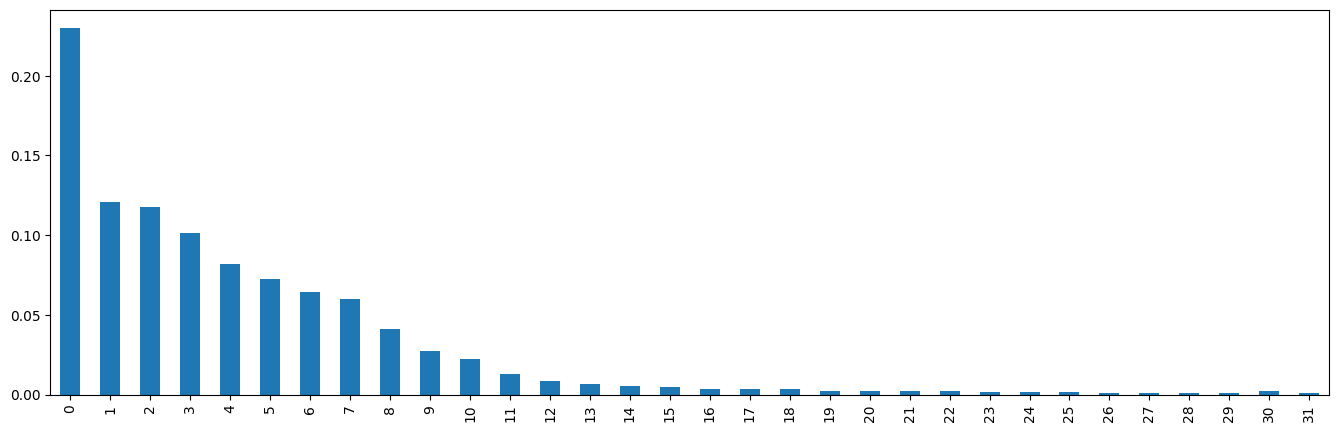

In [6]:
import datetime
import os

DELIMITERS = ['€', '£']

def delimiter_split(value, i=0):
    if not isinstance(value, str):
        return value
    else:
        for d in DELIMITERS:
            if d in value:
                return value.split(d)[i]
        return value
    
def read_table(fname):
    data = pd.read_table(fname, header=None)
    data.columns = ['country', 'b3', 'b2', 'b1', 'l1', 'l2', 'l3']
    data.iloc[:, 1:] = data.iloc[:, 1:].applymap(lambda s: float(delimiter_split(s)))
    data['mid'] = data.loc[:, ['b1', 'l1']].mean(axis=1)
    data['p'] = data.mid.apply(lambda i: 1 / i)
    
    basename = os.path.basename(fname)
    data['date'] = datetime.datetime.strptime(basename.split('.')[0], "%Y%m%d").date()
    data['bet'] = basename.split('.')[1]
    return data

win = read_table(files[-1])
win.p.plot(kind='bar')
win.head()

In [7]:
data = pd.concat([read_table(f) for f in files])
data = data.loc[:, ['country', 'p', 'date', 'bet']]
data['stage'] = data.bet.apply(lambda s: 'qualify' if s in groups else s)
data['date'] = pd.to_datetime(data['date'])

last = data[data.date == sorted(set(data.date))[-1]]
last.to_csv('last.csv', index=False)

last

,country,p,date,bet,stage
0,Netherlands,0.961538,2022-11-22,a,qualify
1,Ecuador,0.638978,2022-11-22,a,qualify
2,Senegal,0.362319,2022-11-22,a,qualify
3,Qatar,0.033898,2022-11-22,a,qualify
0,England,0.952381,2022-11-22,b,qualify
...,...,...,...,...,...
27,Qatar,0.001000,2022-11-22,win,win
28,Tunisia,0.001000,2022-11-22,win,win
29,Iran,0.001000,2022-11-22,win,win
30,Saudi Arabia,0.002299,2022-11-22,win,win


## Probability for Position by Team

In [8]:
stage_name_map = {
    "win": "Win the Tournament",
    "final": "Reach the Finals",
    "semi": "Reach the Semi-Finals",
    "quarter": "Reach the Quarter-Finals",
    "qualify": "Reach the Round of 16"
}

chart = last.copy().loc[:, ['country', 'p', 'stage']]
chart['stage_order'] = chart.stage.apply(lambda b: stage_order_map[b])
chart['stage_nice'] = chart.stage.apply(lambda b: stage_name_map[b])
chart = chart.sort_values('stage_order')
chart['y'] = 0

country_order = list(chart[chart.stage == 'win'].sort_values('p', ascending=False)['country'])

import altair as alt
import pandas as pd

alt.Chart(chart).mark_bar().encode(
    x=alt.X('country:O', axis=alt.Axis(title=""), sort=country_order),
    y=alt.Y('p:Q', axis=alt.Axis(title="Probability", format="%")),
    y2='y',
    color=alt.Color(
        field='stage_nice', type='ordinal', sort=[stage_name_map[b] for b in stage_order][::-1],
        # sort=alt.SortField(op='min', field='bet_order'),
        legend=alt.Legend(title="Position"), scale=alt.Scale(scheme='greens')
    )
)

alt.Chart(...)

## Probability of Winning over Time

In [9]:
alt.Chart(data[data.stage == 'win']).mark_line().encode(
    x=alt.X('date', axis=alt.Axis(title="")),
    y=alt.Y('p:Q', axis=alt.Axis(title="Probability", format="%"), scale=alt.Scale(type="log")),
    color='country',
    tooltip='country'
)

alt.Chart(...)